`antman` kernel

Generate main text plots

In [24]:
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
import seaborn as sns
import sys
from tqdm import tqdm
sys.path.append('../')
from transcriptomics import * 
from plotting import * 
import warnings 
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import ranksums
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', None)

# Load genome
genome_fasta_path = '../genome/Obir.assembly.v5.4.fasta'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

# Load transcriptome
tr = load_transcriptome_object("../transcriptome/biroi_transcriptome.pkl")

# Load or_db
or_db = pd.read_excel('../ORs/OR List.xlsx') 
or_db.loc[or_db.gene_name.isin(['Or5-9E198', 'Or5-9E200', 'Or5-9E201']), 'tandem_array'] = 35

white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

## Make a list of genes in the genome with CDS length 100bp-10kbp

In [25]:
min_cds_length = 100 
max_cds_length = 10000 # 10kbp 

In [26]:
genome_db = pd.DataFrame(columns=['gene_name', 'chromosome', 'start', 'end', 'strand', 'cds_length'])

for gene_name in tr.genes.keys(): 
    gene = tr.get_gene(gene_name)
    if len(gene.transcripts) == 0: 
        continue
    min_start = min([transcript.get_bounds()[0] for transcript in gene.transcripts])
    max_end = max([transcript.get_bounds()[1] for transcript in gene.transcripts])
    length = max_end - min_start
    cds_length = gene.get_transcript_longest_cds().cds_length
    if length >= max_cds_length or cds_length <= min_cds_length:
        continue 
    genome_db = genome_db._append({'gene_name': gene_name, 'chromosome': gene.chromosome, 'start': min_start, 'end': max_end, 'strand': gene.strand, 'cds_length': cds_length}, ignore_index=True)

genome_db

,gene_name,chromosome,start,end,strand,cds_length
0,CSP10.2,Chr13,1251897,1257450,+,354
1,Csp1,Chr10,2992852,2994140,-,375
2,Csp10,Chr13,1227032,1231037,+,354
3,Csp11,Chr10,8970673,8972214,+,441
4,Csp12,Chr5,13419564,13420947,+,363
...,...,...,...,...,...,...
9259,Or5-W1,Chr1,17242051,17244336,-,1341
9260,Or5-X1,Chr1,18406478,18409631,-,1110
9261,Or5-XA1,Chr3,802044,806553,+,1431
9262,Or5-Y1,Chr2,3732298,3735172,+,1161


In [27]:
# Sort genome_db first by chromosome then by end position 
genome_db = genome_db.sort_values(by=['chromosome', 'end'])
genome_db = genome_db.reset_index(drop=True)
genome_db

,gene_name,chromosome,start,end,strand,cds_length
0,LOC105288151,Chr1,1070,7288,+,2613
1,LOC105288134,Chr1,45264,47168,+,648
2,LOC105288138,Chr1,134260,142204,-,2190
3,LOC113562194,Chr1,271139,273181,-,1554
4,LOC105288142,Chr1,273665,275760,+,1110
...,...,...,...,...,...,...
9259,LOC105279494,Chr9,15580792,15586348,-,2451
9260,LOC105279490,Chr9,15587878,15591696,+,1572
9261,LOC105279491,Chr9,15591805,15596813,+,2802
9262,LOC105279492,Chr9,15596831,15598680,-,894


## Find gene pairs with distance 50bp - 10kbp

In [ ]:
# Find adjacent genes: same chromosome, same strand, distance > 5bp 
min_distance = 50 # 50 bp 
max_distance = 10_000 # 10kb 
adjacent_gene_db = pd.DataFrame(columns=['gene_1', 'gene_2', 'chromosome', 'start_1', 'end_1', 'start_2', 'end_2', 'strand_1', 'strand_2', 'distance'])
for i in range(len(genome_db)-1): 
    gene_1 = genome_db.iloc[i]
    gene_2 = genome_db.iloc[i+1]
    if gene_1['chromosome'] == gene_2['chromosome'] and gene_1['strand'] == gene_2['strand'] and gene_1['end'] < gene_2['start']: 
        distance = gene_2['start'] - gene_1['end']
        if distance >= min_distance and distance <= max_distance: 
            adjacent_gene_db = adjacent_gene_db._append({'gene_1': gene_1['gene_name'], 'gene_2': gene_2['gene_name'], 'chromosome': gene_1['chromosome'], 'start_1': gene_1['start'], 'end_1': gene_1['end'], 'start_2': gene_2['start'], 'end_2': gene_2['end'], 'strand_1': gene_1['strand'], 'strand_2': gene_2['strand'], 'distance': distance}, ignore_index=True)

adjacent_gene_db

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance
0,LOC113562288,LOC113562287,Chr1,541732,542562,545053,551825,+,+,2491
1,LOC113561806,LOC105285454,Chr1,634119,635144,635521,637076,-,-,377
2,LOC113562456,LOC105285465,Chr1,968531,974493,975508,979159,-,-,1015
3,LOC113563226,LOC113563227,Chr1,1010456,1015629,1016111,1021594,+,+,482
4,LOC113561379,LOC105286750,Chr1,1087708,1093746,1095614,1100480,+,+,1868
...,...,...,...,...,...,...,...,...,...,...
2725,LOC105279505,LOC105279570,Chr9,15532249,15536098,15537154,15543151,-,-,1056
2726,LOC105279504,LOC105279501,Chr9,15543493,15547966,15548459,15550572,+,+,493
2727,LOC105279498,LOC105279494,Chr9,15571888,15579051,15580792,15586348,-,-,1741
2728,LOC105279490,LOC105279491,Chr9,15587878,15591696,15591805,15596813,+,+,109


## Annotate whether gene pairs are both ORs 

In [ ]:
# Add location of the intergenic region to adjacent_gene_db
adjacent_gene_db['location'] = adjacent_gene_db.apply(lambda x: f"{x["chromosome"]}:{x["end_1"]}-{x["start_2"]}", axis=1)
# Make a column that is true if both genes are in or_db 
adjacent_gene_db['both_ORs'] = adjacent_gene_db.apply(lambda x: x['gene_1'] in or_db['gene_name'].values and x['gene_2'] in or_db['gene_name'].values, axis=1)
# Add a column for TA (tandem array) for each pair in adjacent_gene_db where both_ORs is true using or_db
adjacent_gene_db['TA'] = adjacent_gene_db.apply(lambda x: or_db[or_db['gene_name'] == x['gene_1']]['tandem_array'].values[0] if x['both_ORs'] else None, axis=1)
adjacent_gene_db['TA_size'] = adjacent_gene_db.apply(lambda x: len(or_db[or_db['tandem_array'] == x['TA']]) if x['both_ORs'] else None, axis=1)
adjacent_gene_db['nine-exon'] = adjacent_gene_db.apply(lambda x: ("9E" in x['gene_1'] and "9E" in x['gene_2']) if x["both_ORs"] else "non-OR", axis=1)
adjacent_gene_db['nine-exon'] = adjacent_gene_db['nine-exon'].astype(str)
adjacent_gene_db[adjacent_gene_db['both_ORs'] == True]

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance,location,both_ORs,TA,TA_size,nine-exon
87,Or5-R2,Or5-Q1,Chr1,6504395,6510987,6511625,6514800,-,-,638,Chr1:6510987-6511625,True,70.0,2.0,False
188,Or5-9E4,Or5-9E5,Chr1,17883604,17887432,17889077,17892268,-,-,1645,Chr1:17887432-17889077,True,79.0,12.0,True
189,Or5-9E5,Or5-9Efrag1,Chr1,17889077,17892268,17894999,17896696,-,-,2731,Chr1:17892268-17894999,True,79.0,12.0,True
190,Or5-9Efrag1,Or5-9E6,Chr1,17894999,17896696,17897629,17901737,-,-,933,Chr1:17896696-17897629,True,79.0,12.0,True
191,Or5-9E6,Or5-9E7,Chr1,17897629,17901737,17903405,17907766,-,-,1668,Chr1:17901737-17903405,True,79.0,12.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2701,Or5-E13,Or5-E14,Chr9,14875775,14879371,14879478,14882434,-,-,107,Chr9:14879371-14879478,True,86.0,16.0,False
2704,Or5-E15,Or5-E16,Chr9,14886183,14888412,14892004,14895862,-,-,3592,Chr9:14888412-14892004,True,86.0,16.0,False
2705,Or5-E16,Or5-E17,Chr9,14892004,14895862,14899946,14901917,-,-,4084,Chr9:14895862-14899946,True,86.0,16.0,False
2706,Or5-E17,Or5-E18,Chr9,14899946,14901917,14902605,14904727,-,-,688,Chr9:14901917-14902605,True,86.0,16.0,False


## Remove any pairs that are overlapping with existing features
For instance if a gene is within the intron of another gene or overlaps with an antisense lncRNA 

In [ ]:
all_genes = [tr.get_gene(gene) for gene in tr.genes.keys() if len(tr.get_gene(gene).transcripts) > 0]
all_chr = list(set([gene.chromosome for gene in all_genes]))

In [ ]:
chr_features = {} 
for chr_name in all_chr: 
    chr_features[chr_name] = []
    for gene in all_genes: 
        if gene.chromosome == chr_name: 
            for transcript in gene.transcripts: 
                for exon in transcript.exons: 
                    chr_features[chr_name].append(exon)
                for intron in transcript.introns: 
                    chr_features[chr_name].append(intron)

In [ ]:
def overlapping(chr1, start1, end1, chr2, start2, end2, min_overlap=0): 
    """ Returns true if the two regions overlap by at least min_overlap bases """
    # Check if the two regions are on the same chromosome
    if chr1 != chr2: 
        return False
    # Check if the two regions overlap by at least min_overlap bases
    overlap = max(0, min(end1, end2) - max(start1, start2))
    return overlap >= min_overlap

In [ ]:
# Assume overlapping is defined and works on individual rows
adjacent_gene_db['overlapping_feature'] = False

for chr in tqdm(all_chr, desc='Chromosome'):
    # Get indices of genes on the current chromosome
    chr_gene_indices = adjacent_gene_db.index[adjacent_gene_db['chromosome'] == chr]
    # Iterate over features on the current chromosome
    for feature in chr_features[chr]:
        # Check for overlaps with genes on the current chromosome
        overlaps = adjacent_gene_db.loc[chr_gene_indices].apply(
            lambda row: overlapping(
                row['chromosome'], row['end_1'], row['start_2'],
                feature.chromosome, feature.position[0], feature.position[1],
                min_overlap=5
            ),
            axis=1
        )
        adjacent_gene_db.loc[overlaps.index[overlaps], 'overlapping_feature'] = True

Chromosome:   0%|          | 0/14 [00:00<?, ?it/s]

Chromosome: 100%|██████████| 14/14 [29:56<00:00, 128.33s/it]


In [ ]:
# Get the number of adjacent genes that overlap with a feature
adjacent_gene_db[adjacent_gene_db['overlapping_feature'] == True].shape[0]

617

In [ ]:
# Remove the adjacent genes that overlap with a feature
adjacent_gene_db_nonoverlapping = adjacent_gene_db[adjacent_gene_db['overlapping_feature'] == False].copy() 

In [ ]:
# Save the non-overlapping adjacent genes to a file
adjacent_gene_db_nonoverlapping.to_csv('../results/adjacent_gene_db_nonoverlapping.csv', index=False)

In [29]:
# Load cached adjacent_gene_db_nonoverlapping
adjacent_gene_db_nonoverlapping = pd.read_csv('../results/adjacent_gene_db_nonoverlapping.csv')
adjacent_gene_db_nonoverlapping.shape

(2113, 16)

## Take a random sample of the non-OR gene pairs equal to the number of OR gene pairs 

In [30]:
# For adjacent_gene_db, take all OR intergenic regions and an equal number of non-OR regions 
ORs = adjacent_gene_db_nonoverlapping[adjacent_gene_db_nonoverlapping['both_ORs'] == True].copy() 
non_ORs = adjacent_gene_db_nonoverlapping[adjacent_gene_db_nonoverlapping['both_ORs'] == False].copy() 
non_ORs = non_ORs.sample(n=ORs.shape[0], random_state=0)
adjacent_gene_db_subset = pd.concat([ORs, non_ORs])
adjacent_gene_db_subset = adjacent_gene_db_subset.reset_index(drop=True)
adjacent_gene_db_subset

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance,location,both_ORs,TA,TA_size,nine-exon,overlapping_feature
0,Or5-R2,Or5-Q1,Chr1,6504395,6510987,6511625,6514800,-,-,638,Chr1:6510987-6511625,True,70.0,2.0,False,False
1,Or5-9E4,Or5-9E5,Chr1,17883604,17887432,17889077,17892268,-,-,1645,Chr1:17887432-17889077,True,79.0,12.0,True,False
2,Or5-9E5,Or5-9Efrag1,Chr1,17889077,17892268,17894999,17896696,-,-,2731,Chr1:17892268-17894999,True,79.0,12.0,True,False
3,Or5-9Efrag1,Or5-9E6,Chr1,17894999,17896696,17897629,17901737,-,-,933,Chr1:17896696-17897629,True,79.0,12.0,True,False
4,Or5-H1,Or5-X1,Chr1,18401037,18404290,18406478,18409631,-,-,2188,Chr1:18404290-18406478,True,80.0,4.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,LOC105283518,LOC105281894,Chr6,6629890,6630504,6636115,6637004,+,+,5611,Chr6:6630504-6636115,False,NaN,NaN,non-OR,False
418,LOC105279251,LOC105279249,Chr7,7897818,7905340,7905682,7908445,+,+,342,Chr7:7905340-7905682,False,NaN,NaN,non-OR,False
419,LOC105287814,LOC105287815,Chr8,3144818,3145709,3146624,3152807,+,+,915,Chr8:3145709-3146624,False,NaN,NaN,non-OR,False
420,LOC105278096,LOC105278095,Chr3,9086318,9091709,9095878,9098672,-,-,4169,Chr3:9091709-9095878,False,NaN,NaN,non-OR,False


## Average distance between genes split by chromosome 

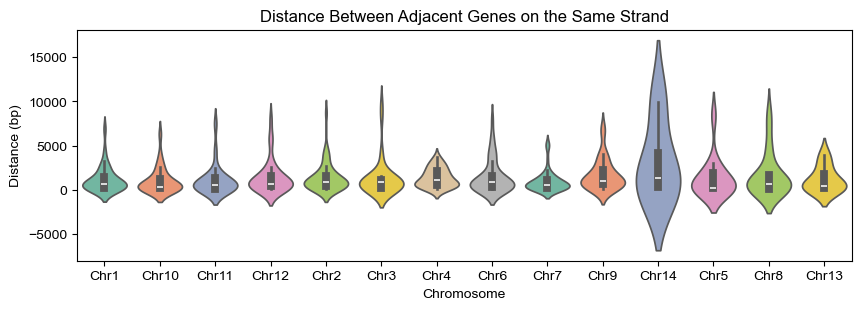

In [31]:
# Plot the average distance for for adjacent genes on the same strand, split by chromosome
fig, ax = plt.subplots(figsize=(10, 3))
sns.violinplot(x='chromosome', y='distance', data=adjacent_gene_db_subset, ax=ax, palette='Set2')
plt.title('Distance Between Adjacent Genes on the Same Strand')
plt.xlabel('Chromosome')
plt.ylabel('Distance (bp)')
plt.show()

## Histograms of intergenic distance for OR and non-OR gene pairs 

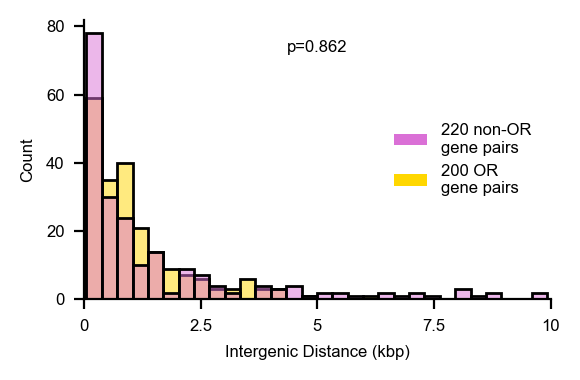

In [32]:
# Plot overlapping histograms of the intergenic distance for OR and non-OR adjacent genes
fig, ax = plt.subplots(figsize=(3, 2), dpi=200)
colors = ['orchid', 'gold']
sns.histplot(data=adjacent_gene_db_subset, x='distance', hue_order=[False, True], hue='both_ORs', bins=30, kde=False, palette=colors, legend=False, linewidth=1)
#plt.title('Intergenic Distance Between Genes of Interest', fontsize=6)
plt.xlabel('Intergenic Distance (kbp)', fontsize=6)
plt.ylabel('Count', fontsize=6)
# artificial legend 
plt.bar(0, 0, color=colors[0], label='220 non-OR \ngene pairs')
plt.bar(0, 0, color=colors[1], label='200 OR \ngene pairs')
plt.legend(fontsize=6, frameon=False, loc='center right')
plt.xlim(0, 10000)

# Are the distributions of intergenic distances for OR and non-OR adjacent genes significantly different?
OR_distances = adjacent_gene_db_subset[adjacent_gene_db_subset['both_ORs'] == True]['distance']
non_OR_distances = adjacent_gene_db_subset[adjacent_gene_db_subset['both_ORs'] == False]['distance']
r, p = ranksums(OR_distances, non_OR_distances)
p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
plt.text(0.5, 0.9, p_value_str, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=6)

# y and x ticks font size
plt.xticks([0, 2500, 5000, 7500, 10000], labels=[0, 2.5, 5, 7.5, 10], fontsize=6)
plt.yticks(fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f"../figures/intergenic-distances-histograms_no_title.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## Define functions for querying polyA and rRNA data

In [33]:
def get_coverage_rRNA_depleted(tissue, orientation, chrom, start, end): 
    base_path = '../first_of_pair_strand_coverage_chrom_h5'
    # Check that orientation is fwd or rev 
    assert orientation in ['fwd', 'rev'], "Orientation must be 'fwd' or 'rev'"
    # Replace fwd and rev with forward and reverse 
    orientation = 'forward' if orientation == 'fwd' else 'reverse'
    # Get the file path
    file_path = f"{base_path}/{tissue}_renamed_{orientation}_strand_coverage.h5"

    # Reading data
    with h5py.File(file_path, 'r') as f:
        chr_data = f[chrom][:]
    
    # Checks 
    assert 0 <= start < len(chr_data), "Start index is out of range"
    assert 0 < end <= len(chr_data), "End index is out of range"
    assert start < end, "Start must be less than end"

    # Return the coverage values for the specified range
    return chr_data[start:end]


In [34]:
def get_coverage_polyA_female(sample, orientation, chrom, start, end): 
    base_path = '../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage_chrom_h5'
    # Check that orientation is fwd or rev 
    assert orientation in ['fwd', 'rev'], "Orientation must be 'fwd' or 'rev'"
    # Replace fwd and rev with forward and reverse 
    orientation = 'forward' if orientation == 'fwd' else 'reverse'
    # Get the file path
    file_path = f"{base_path}/{sample}_Aligned.sortedByCoord.out_{orientation}_strand_coverage.h5"

    # Reading data
    with h5py.File(file_path, 'r') as f:
        chr_data = f[chrom][:]
    
    # Checks 
    assert 0 <= start < len(chr_data), "Start index is out of range"
    assert 0 < end <= len(chr_data), "End index is out of range"
    assert start < end, "Start must be less than end"

    # Return the coverage values for the specified range
    return chr_data[start:end]

## Read in rRNA-Depleted RNAseq Data 
- 16 minutes 

In [35]:
def process_tissue(tissue, adjacent_gene_db):
    tissue_db = adjacent_gene_db.copy()
    for i, row in adjacent_gene_db.iterrows():
        chrom = row['chromosome']
        upstream_gene = row['gene_1'] if row['strand_1'] == '+' else row['gene_2']
        upstream_transcript = tr.get_gene(upstream_gene).get_transcript_longest_cds()

        # Process exons
        if len(upstream_transcript.exons) > 0:
            exon_fwd_coverage = np.concatenate([
                get_coverage_rRNA_depleted(tissue, 'fwd', chrom, start, end)
                for start, end in (exon.position for exon in upstream_transcript.exons)
            ], axis=0)
            exon_rev_coverage = np.concatenate([
                get_coverage_rRNA_depleted(tissue, 'rev', chrom, start, end)
                for start, end in (exon.position for exon in upstream_transcript.exons)
            ], axis=0)

            # Save exon coverage
            tissue_db.at[i, f'upstream_exon_fwd_{tissue}'] = exon_fwd_coverage.mean() 
            tissue_db.at[i, f'upstream_exon_rev_{tissue}'] = exon_rev_coverage.mean() 

        # Process introns
        if len(upstream_transcript.introns) > 0: 
            intron_fwd_coverage = np.concatenate([
                get_coverage_rRNA_depleted(tissue, 'fwd', chrom, start, end)
                for start, end in (intron.position for intron in upstream_transcript.introns)
            ], axis=0)
            intron_rev_coverage = np.concatenate([
                get_coverage_rRNA_depleted(tissue, 'rev', chrom, start, end)
                for start, end in (intron.position for intron in upstream_transcript.introns)
            ], axis=0)

            # Save intron coverage
            tissue_db.at[i, f'upstream_intron_fwd_{tissue}'] = intron_fwd_coverage.mean() 
            tissue_db.at[i, f'upstream_intron_rev_{tissue}'] = intron_rev_coverage.mean() 

        # Process intergenic regions
        end_1, start_2 = row['end_1'], row['start_2'] 
        fwd_cov = get_coverage_rRNA_depleted(tissue, 'fwd', chrom, end_1, start_2)
        rev_cov = get_coverage_rRNA_depleted(tissue, 'rev', chrom, end_1, start_2)
        tissue_db.at[i, f'intergenic_fwd_{tissue}'] = fwd_cov.mean()
        tissue_db.at[i, f'intergenic_rev_{tissue}'] = rev_cov.mean()
        tissue_db.at[i, f'intergenic_fwd_prop_{tissue}'] = (fwd_cov > 0).sum() / len(fwd_cov) 
        tissue_db.at[i, f'intergenic_rev_prop_{tissue}'] = (rev_cov > 0).sum() / len(rev_cov) 

    return tissue_db

# Main processing function
def process_all_tissues(tissues, adjacent_gene_db):
    results = []
    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(process_tissue, tissue, adjacent_gene_db): tissue for tissue in tissues}
        for future in futures:
            result = future.result()
            if result is not None:
                results.append(result)

    # Merge results back into the main database
    for result in results:
        for col in result.columns:
            if col not in adjacent_gene_db.columns:
                adjacent_gene_db[col] = None  # Add new columns to main DB
        adjacent_gene_db.update(result)


#tissues = ['4thInstarLarvae_S3', 'Adults_S6', 'Eggs_S1', 'Prepupae_S4', 'Pupae_S5', 'YoungLarvae_S2']
tissues = ['Pupae_S5']
process_all_tissues(tissues, adjacent_gene_db_subset)

In [44]:
# Save results 
adjacent_gene_db_subset.to_csv('../results/adjacent_gene_db_subset_coverage_20250524.csv', index=False)

In [45]:
# Load cached results 
adjacent_gene_db_subset = pd.read_csv('../results/adjacent_gene_db_subset_coverage_20250524.csv')
adjacent_gene_db_subset.shape

(422, 36)

In [46]:
adjacent_gene_db_subset

,gene_1,gene_2,chromosome,start_1,end_1,start_2,end_2,strand_1,strand_2,distance,location,both_ORs,TA,TA_size,nine-exon,overlapping_feature,upstream_exon_fwd_Pupae_S5,upstream_exon_rev_Pupae_S5,upstream_intron_fwd_Pupae_S5,upstream_intron_rev_Pupae_S5,intergenic_fwd_Pupae_S5,intergenic_rev_Pupae_S5,intergenic_fwd_prop_Pupae_S5,intergenic_rev_prop_Pupae_S5,upstream_exon_same_Pupae_S5,upstream_exon_opp_Pupae_S5,upstream_intron_same_Pupae_S5,upstream_intron_opp_Pupae_S5,intergenic_same_Pupae_S5,intergenic_opp_Pupae_S5,exon_same_rel_Pupae_S5,exon_opp_rel_Pupae_S5,intron_same_rel_Pupae_S5,intron_opp_rel_Pupae_S5,intergenic_same_rel_Pupae_S5,intergenic_opp_rel_Pupae_S5
0,Or5-R2,Or5-Q1,Chr1,6504395,6510987,6511625,6514800,-,-,638,Chr1:6510987-6511625,True,70.0,2.0,False,False,0.128225,1.707891,0.071003,0.048238,0.000000,0.000000,0.000000,0.000000,1.707891,0.128225,0.048238,0.071003,0.000000,0.000000,1.0,0.075078,0.028244,0.041573,0.000000,0.000000
1,Or5-9E4,Or5-9E5,Chr1,17883604,17887432,17889077,17892268,-,-,1645,Chr1:17887432-17889077,True,79.0,12.0,True,False,0.682143,5.787500,0.236437,0.918285,1.245593,1.111246,0.497264,0.628571,5.787500,0.682143,0.918285,0.236437,1.111246,1.245593,1.0,0.117865,0.158667,0.040853,0.192008,0.215221
2,Or5-9E5,Or5-9Efrag1,Chr1,17889077,17892268,17894999,17896696,-,-,2731,Chr1:17892268-17894999,True,79.0,12.0,True,False,2.533964,1.574377,1.414773,0.378788,0.809227,0.394727,0.481875,0.159648,1.574377,2.533964,0.378788,1.414773,0.394727,0.809227,1.0,1.609503,0.240595,0.898624,0.250720,0.513999
3,Or5-9Efrag1,Or5-9E6,Chr1,17894999,17896696,17897629,17901737,-,-,933,Chr1:17896696-17897629,True,79.0,12.0,True,False,2.043594,3.029804,1.857220,1.311075,2.093248,0.700965,0.821008,0.312969,3.029804,2.043594,1.311075,1.857220,0.700965,2.093248,1.0,0.674497,0.432726,0.612984,0.231356,0.690885
4,Or5-H1,Or5-X1,Chr1,18401037,18404290,18406478,18409631,-,-,2188,Chr1:18404290-18406478,True,80.0,4.0,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.138026,0.000000,0.087751,0.000000,0.000000,0.000000,0.000000,0.138026,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,LOC105283518,LOC105281894,Chr6,6629890,6630504,6636115,6637004,+,+,5611,Chr6:6630504-6636115,False,NaN,NaN,non-OR,False,0.052117,0.000000,NaN,NaN,0.209588,0.000000,0.116022,0.000000,0.052117,0.000000,NaN,NaN,0.209588,0.000000,1.0,0.000000,NaN,NaN,4.021476,0.000000
418,LOC105279251,LOC105279249,Chr7,7897818,7905340,7905682,7908445,+,+,342,Chr7:7905340-7905682,False,NaN,NaN,non-OR,False,808.217873,2.483141,87.235168,7.561635,16.538012,0.000000,1.000000,0.000000,808.217873,2.483141,87.235168,7.561635,16.538012,0.000000,1.0,0.003072,0.107935,0.009356,0.020462,0.000000
419,LOC105287814,LOC105287815,Chr8,3144818,3145709,3146624,3152807,+,+,915,Chr8:3145709-3146624,False,NaN,NaN,non-OR,False,242.904602,1.586981,NaN,NaN,24.004372,2.075410,1.000000,0.545355,242.904602,1.586981,NaN,NaN,24.004372,2.075410,1.0,0.006533,NaN,NaN,0.098822,0.008544
420,LOC105278096,LOC105278095,Chr3,9086318,9091709,9095878,9098672,-,-,4169,Chr3:9091709-9095878,False,NaN,NaN,non-OR,False,0.019149,43.798936,1.118635,2.366739,0.552411,17.655793,0.169345,0.312785,43.798936,0.019149,2.366739,1.118635,17.655793,0.552411,1.0,0.000437,0.054036,0.025540,0.403110,0.012612


#### Assign "fwd" and "rev" coverage to "same" strand vs "opposite" strand depending on orientation of gene pairs

In [47]:
# Define same and opp strand coverage for each variable 
tissues = ['Pupae_S5']
for tissue in tissues:
    adjacent_gene_db_subset[f'upstream_exon_same_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_exon_fwd_{tissue}'] if x['strand_1'] == '+' else x[f'upstream_exon_rev_{tissue}'], axis=1)
    adjacent_gene_db_subset[f'upstream_exon_opp_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_exon_rev_{tissue}'] if x['strand_1'] == '+' else x[f'upstream_exon_fwd_{tissue}'], axis=1)
    adjacent_gene_db_subset[f'upstream_intron_same_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_intron_fwd_{tissue}'] if x['strand_1'] == '+' else x[f'upstream_intron_rev_{tissue}'], axis=1)
    adjacent_gene_db_subset[f'upstream_intron_opp_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_intron_rev_{tissue}'] if x['strand_1'] == '+' else x[f'upstream_intron_fwd_{tissue}'], axis=1)
    adjacent_gene_db_subset[f'intergenic_same_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'intergenic_fwd_{tissue}'] if x['strand_1'] == '+' else x[f'intergenic_rev_{tissue}'], axis=1)
    adjacent_gene_db_subset[f'intergenic_opp_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'intergenic_rev_{tissue}'] if x['strand_1'] == '+' else x[f'intergenic_fwd_{tissue}'], axis=1)

In [48]:
adjacent_gene_db_subset.shape

(422, 36)

#### Calculate relative coverage by normalizing by the upstream exon coverage

In [49]:
# Normalize coverage by exon_same_coverage
tissues = ['Pupae_S5']
for tissue in tissues:
    adjacent_gene_db_subset[f'exon_same_rel_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_exon_same_{tissue}'] / x[f'upstream_exon_same_{tissue}'] if x[f'upstream_exon_same_{tissue}'] > 0 else None, axis=1)
    adjacent_gene_db_subset[f'exon_opp_rel_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_exon_opp_{tissue}'] / x[f'upstream_exon_same_{tissue}'] if x[f'upstream_exon_same_{tissue}'] > 0 else None, axis=1)
    adjacent_gene_db_subset[f'intron_same_rel_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_intron_same_{tissue}'] / x[f'upstream_exon_same_{tissue}'] if x[f'upstream_exon_same_{tissue}'] > 0 else None, axis=1)
    adjacent_gene_db_subset[f'intron_opp_rel_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'upstream_intron_opp_{tissue}'] / x[f'upstream_exon_same_{tissue}'] if x[f'upstream_exon_same_{tissue}'] > 0 else None, axis=1)
    adjacent_gene_db_subset[f'intergenic_same_rel_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'intergenic_same_{tissue}'] / x[f'upstream_exon_same_{tissue}'] if x[f'upstream_exon_same_{tissue}'] > 0 else None, axis=1)
    adjacent_gene_db_subset[f'intergenic_opp_rel_{tissue}'] = adjacent_gene_db_subset.apply(lambda x: x[f'intergenic_opp_{tissue}'] / x[f'upstream_exon_same_{tissue}'] if x[f'upstream_exon_same_{tissue}'] > 0 else None, axis=1)

### Plot relative mean coverage 

In [50]:
# Plot fwd_coverage_adult_intron_rel and rev_coverage_adult_intron_rel split by both_ORs

tissue = 'Pupae_S5'

# Melt adjacent_gene_db for plotting
adjacent_gene_db_melted = adjacent_gene_db_subset.melt(
    id_vars=['both_ORs', 'nine-exon'],
    value_vars=[f'exon_same_rel_{tissue}', f'exon_opp_rel_{tissue}', f'intron_same_rel_{tissue}', f'intron_opp_rel_{tissue}', f'intergenic_same_rel_{tissue}', f'intergenic_opp_rel_{tissue}'],
    var_name='coverage_type',
    value_name='coverage'
) 

adjacent_gene_db_melted['same'] = adjacent_gene_db_melted['coverage_type'].str.contains('same')
adjacent_gene_db_melted['Type'] = adjacent_gene_db_melted['both_ORs'].apply(lambda x: "OR" if x==True else "non-OR")

# Remove NaN Rows using coverage column 
adjacent_gene_db_melted = adjacent_gene_db_melted[~adjacent_gene_db_melted['coverage'].isna()]


In [51]:
# Calculate p-values for ranksum tests
strands = ['same', 'opp']
coverage_types = ['exon', 'intron', 'intergenic']
p_values = []

for strand in strands: 
    x = 0 
    for coverage_type in coverage_types: 
        if strand == "same" and coverage_type == "exon":
            continue
        non_OR_coverage = adjacent_gene_db_melted[(adjacent_gene_db_melted['both_ORs'] == False) & (adjacent_gene_db_melted['coverage_type'] == f'{coverage_type}_{strand}_rel_{tissue}')]['coverage']
        OR_coverage = adjacent_gene_db_melted[(adjacent_gene_db_melted['both_ORs'] == True) & (adjacent_gene_db_melted['coverage_type'] == f'{coverage_type}_{strand}_rel_{tissue}')]['coverage']
        r, p = ranksums(non_OR_coverage, OR_coverage)
        p_values.append({'strand': strand, 'coverage_type': coverage_type, 'x': x, 'p': p})
        x += 1

p_values = pd.DataFrame(p_values)

# Benjamini-Hochberg (BH) False Discovery Rate (FDR) Correction
from statsmodels.stats.multitest import multipletests
p_values['corrected_p'] = multipletests(p_values['p'], method='fdr_bh')[1]
p_values

,strand,coverage_type,x,p,corrected_p
0,same,intron,0,1.171819e-35,1.464774e-35
1,same,intergenic,1,3.334203e-19,3.334203e-19
2,opp,exon,0,2.764221e-46,1.382110e-45
3,opp,intron,1,2.965910e-44,7.414776e-44
4,opp,intergenic,2,3.557081e-37,5.928468e-37


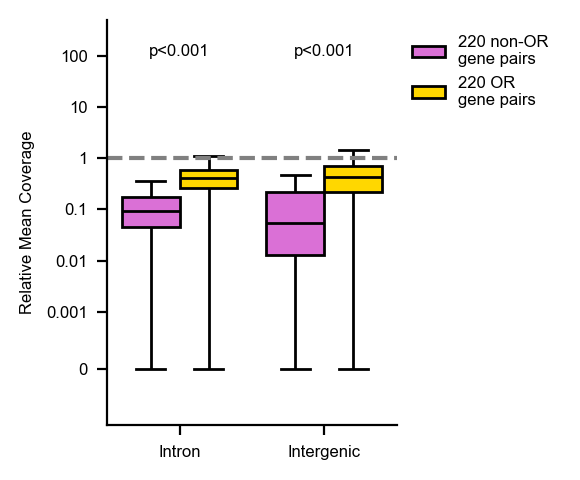

In [52]:
plt.figure(figsize=(3, 2.5), dpi=200)
sns.boxplot(
    data=adjacent_gene_db_melted[(adjacent_gene_db_melted['same'] == True) & (adjacent_gene_db_melted['coverage_type'].str.contains('exon') == False)],
    x='coverage_type',
    y='coverage',
    hue='Type',
    palette=['orchid', 'gold'],
    saturation = 1, 
    linecolor='black',
    linewidth=1,
    fliersize=0,
    hue_order=['non-OR', 'OR'],
    order=[f'intron_same_rel_{tissue}', f'intergenic_same_rel_{tissue}']
)

plt.xticks(range(2), ['Intron', 'Intergenic'], rotation=0, fontsize=6)
#plt.title('Coding Strand Coverage Relative to \n Coding Strand Exon Coverage', fontsize=6)
plt.xlabel('')
plt.ylabel('Relative Mean Coverage', fontsize=6)
plt.yscale('symlog', linthresh=1e-3)
plt.ylim(-0.001, 500)
plt.yticks([0, 0.001, 0.01, 0.1, 1, 10, 100], labels = [0, 0.001, 0.01, 0.1, 1, 10, 100], fontsize=6)
plt.axhline(1, color='grey', linestyle='--', lw=1.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Add p-values to the first plot
for i, row in p_values[p_values['strand'] == 'same'].iterrows():
    p_value_str = f"p={row['corrected_p']:.3f}" if row['corrected_p'] >= 0.001 else "p<0.001"
    plt.text(row['x'], 100, p_value_str, ha='center', fontsize=6)

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['220 non-OR \ngene pairs', '220 OR \ngene pairs']
plt.legend(handles, labels, loc='upper left', fontsize=6, frameon=False, bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig(f"../figures/same_strand_coverage_intron_intergenics_no_title.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

plt.show()

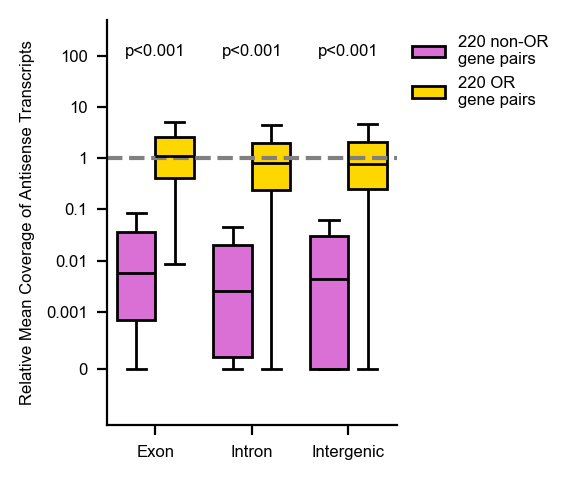

In [53]:
plt.figure(figsize=(3, 2.5), dpi=200)
sns.boxplot(
    data=adjacent_gene_db_melted[adjacent_gene_db_melted['same'] == False],
    x='coverage_type',
    y='coverage',
    hue='Type',
    palette=['orchid', 'gold'],
    linecolor='black',
    linewidth=1,
    saturation = 1, 
    fliersize=0,
    hue_order=['non-OR', 'OR'],
    order=[f'exon_opp_rel_{tissue}', f'intron_opp_rel_{tissue}', f'intergenic_opp_rel_{tissue}']
)

plt.xticks(range(3), ['Exon', 'Intron', 'Intergenic'], rotation=0, fontsize=6)
#plt.title('Non-coding Strand Coverage Relative to \nCoding Strand Exon Coverage', fontsize=6)
plt.xlabel('')
plt.ylabel('Relative Mean Coverage of Antisense Transcripts', fontsize=6)
plt.yscale('symlog', linthresh=1e-3)
plt.ylim(-0.001, 500)
plt.yticks([0, 0.001, 0.01, 0.1, 1, 10, 100], labels = [0, 0.001, 0.01, 0.1, 1, 10, 100], fontsize=6)
plt.axhline(1, color='grey', linestyle='--', lw=1.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Add p-values to the second plot
for i, row in p_values[p_values['strand'] == 'opp'].iterrows():
    p_value_str = f"p={row['corrected_p']:.3f}" if row['corrected_p'] >= 0.001 else "p<0.001"
    plt.text(row['x'], 100, p_value_str, ha='center', fontsize=6)

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['220 non-OR \ngene pairs', '220 OR \ngene pairs']
plt.legend(handles, labels, loc='upper left', fontsize=6, frameon=False, bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig(f"../figures/opp_strand_cov_exon_intron_intergenic_no_title.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

plt.show()

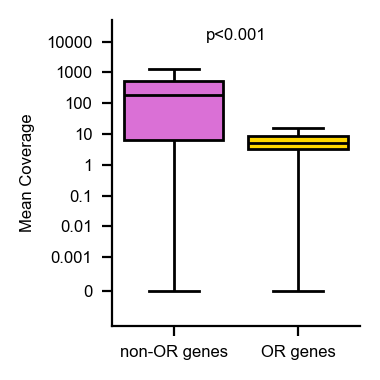

In [54]:
# Plot same_strand_coverage and opp_strand_coverage split by both_ORs
fig, ax = plt.subplots(1, 1, figsize=(2, 2), sharey=True, dpi=200) 
plt.subplots_adjust(wspace=0.3, hspace=0.3)

sns.boxplot(
    x='both_ORs', 
    y=f'upstream_exon_same_{tissue}', 
    data=adjacent_gene_db_subset, 
    ax=ax, 
    palette=['orchid', 'gold'], 
    linecolor='black', 
    linewidth=1, 
    saturation=1,
    fliersize=0
)

# P values 
OR_same = adjacent_gene_db_subset[adjacent_gene_db_subset['both_ORs'] == True][f'upstream_exon_same_{tissue}']
non_OR_same = adjacent_gene_db_subset[adjacent_gene_db_subset['both_ORs'] == False][f'upstream_exon_same_{tissue}']
r, p = ranksums(OR_same, non_OR_same)
p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
ax.text(0.5, 0.95, p_value_str, ha='center', va='center', transform=ax.transAxes, fontsize=6)


#ax.set_title(f'Coding Strand Exon Coverage', fontsize=6)
ax.set_xlabel('')
ax.set_ylabel('Mean Coverage', fontsize=6)
ax.set_xticks([0, 1], labels=['non-OR genes', 'OR genes'], fontsize=6)
ax.set_yscale('symlog', linthresh=1e-3)
ax.set_ylim(-0.001, 50_000)
ax.set_yticks([0, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], labels=[0, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], fontsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
plt.tight_layout()
plt.savefig(f"../figures/raw_exon_coverage_no_title.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

plt.show()